In [2]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import os
import re

In [4]:
### Purple Air Data
# Regular Expressions to get correct files, and information about the sites
re_files = re.compile(".*\(outside\).*Primary.*")
re_lat = re.compile("(?<= \()\d{2}\.\d*")
re_lon = re.compile("(?<=\d )-\d{3}\.\d*")
re_site_name = re.compile(".*(?= \(outside)")
obs_data = {}
obs_data_files = list(filter(re_files.match, os.listdir('/import/home/njune1_ua/WRFChemEval/PurpleAirData')))
for file in obs_data_files:
    obs_site = pd.read_csv('/import/home/njune1_ua/WRFChemEval/PurpleAirData/'+file)
    site_name = re_site_name.match(file).group()
    site_lat = re_lat.search(file).group()
    site_lon = re_lon.search(file).group()
    obs_site['site_name'] = site_name
    obs_site['LAT'] = float(site_lat)
    obs_site['LON'] = float(site_lon)
    obs_data[site_name] = obs_site

PermissionError: [Errno 13] Permission denied: '/import/home/njune1_ua/WRFChemEval/PurpleAirData'

In [4]:
obs_data

NameError: name 'obs_data' is not defined

In [5]:
obs_data_DEC = pd.read_csv('/import/home/njune1_ua/WRFChemEval/DEC_May_June_2019.csv',index_col=False)
obs_data_DEC = obs_data.set_index('date_gmt')

FileNotFoundError: [Errno 2] File /import/home/njune1_ua/WRFChemEval/DEC_May_June_2019.csv does not exist: '/import/home/njune1_ua/WRFChemEval/DEC_May_June_2019.csv'

In [3]:
# Observation Data for Each day
obs_data_jun= obs_data.loc[['2019-06-20','2019-06-21','2019-06-22','2019-06-23','2019-06-24','2019-06-25','2019-06-26','2019-06-27','2019-06-28','2019-06-29']]
obs_data_jun = obs_data_jun.reset_index()
PM25_jun = obs_data_jun[obs_data_jun['parameter']=='PM2.5 Raw Data']
PM25_obs = np.array(PM25_jun['sample_measurement'])

In [4]:
# Model Data
lat_site = obs_data['latitude'][0]
lon_site = obs_data['longitude'][0]
dates = ['2019-06-20','2019-06-21','2019-06-22','2019-06-23','2019-06-24','2019-06-25','2019-06-26','2019-06-27','2019-06-28','2019-06-29']
PM25_mod = []
for date in dates:
    file = '/import/archive/GREENING/mstuefer/uafsmoke_wrfout/'+date[0:4]+date[5:7]+date[8:10]+'00/wrfout_d01_'+date+'_00:00:00'
    data = xr.open_dataset(file)
    lon = data['XLONG'][0,:,:]
    lat = data['XLAT'][0,:,:]
    PM25_mod_date = []
    for time in range(0,24):
        PM25_MOD = np.array(data['PM2_5_DRY'].values[time,0,:,:])
        site_index = np.unravel_index(np.argmin(abs(lat-lat_site)+abs(lon-lon_site)),lat.shape)
        PM25_site = PM25_MOD[site_index]
        PM25_mod_date.append(PM25_site)
    PM25_mod.append(PM25_mod_date)
PM25_mod = np.reshape(PM25_mod,(240,))
PM25_obs = np.reshape(PM25_obs,(240,))

[Text(0, 0, '6/20'),
 Text(0, 0, '6/21'),
 Text(0, 0, '6/22'),
 Text(0, 0, '6/23'),
 Text(0, 0, '6/24'),
 Text(0, 0, '6/25'),
 Text(0, 0, '6/26'),
 Text(0, 0, '6/27'),
 Text(0, 0, '6/28'),
 Text(0, 0, '6/29')]

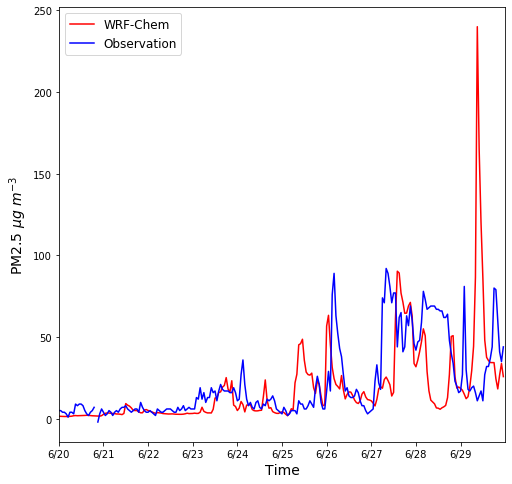

In [5]:
# WRF Chem and Observation Line Graph
time = np.arange(0,240)
plt.figure(figsize=(8,8))
plt.plot(time,PM25_mod,'r',time,PM25_obs,'b')
plt.legend(['WRF-Chem','Observation'],fontsize=12)
plt.xlabel('Time',fontsize=14)
plt.ylabel('PM2.5 $\mu g$ $m^{-3}$',fontsize=14)
plt.xlim(0,240)
ax = plt.gca()
ax.set_xticks([0,24,48,72,96,120,144,168,192,216])
ax.set_xticklabels(['6/20','6/21','6/22','6/23','6/24','6/25','6/26','6/27','6/28','6/29'])

Text(0, 0.5, 'PM2.5')

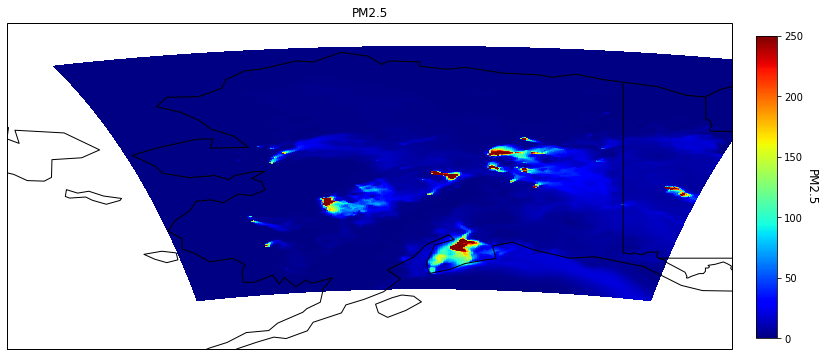

In [6]:
T2 = data['PM2_5_DRY'][12,0,:,:]
c = 'jet'
e = 'k'
extent = [-175, -135, 55, 73]
plt.figure(figsize=(15, 6))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent(extent,ccrs.PlateCarree())
cb = ax.pcolormesh(lon,lat,T2,transform=ccrs.PlateCarree(),cmap=c,vmin=0,vmax=250)
ax = plt.gca()
ax.coastlines(color='k')
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m',edgecolor='k', facecolor='none'))
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m',edgecolor='k', facecolor='none'))
ax.set_title('PM2.5')
fig = plt.gcf()
fig.subplots_adjust(right=0.8,hspace=0.05,wspace=0.05)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = plt.colorbar(cb,cbar_ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('PM2.5', rotation=270,fontsize=12)

In [7]:
def smafit(X0,Y0,W0=None,cl=0.95,intercept=True,robust=False,rmethod='FastMCD'):
    """Standard Major-Axis (SMA) line fitting
    
    Calculate standard major axis, aka reduced major axis, fit to 
    data X and Y. The main advantage of this over ordinary least squares is 
    that the best fit of Y to X will be the same as the best fit of X to Y.
    
    The fit equations and confidence intervals are implemented following 
    Warton et al. (2006). Robust fits use the FastMCD covariance estimate 
    from Rousseeuw and Van Driessen (1999). While there are many alternative 
    robust covariance estimators (e.g. other papers by D.I. Warton using M-estimators), 
    the FastMCD algorithm is default in Matlab. When the standard error or 
    uncertainty of each point is known, then weighted SMA may be preferrable to 
    robust SMA. The conventional choice of weights for each point i is 
    W_i = 1 / ( var(X_i) + var(Y_i) ), where var() is the variance 
    (squared standard error).
    
    References 
    Warton, D. I., Wright, I. J., Falster, D. S. and Westoby, M.: 
        Bivariate line-fitting methods for allometry, Biol. Rev., 81(02), 259, 
        doi:10.1017/S1464793106007007, 2006.
    Rousseeuw, P. J. and Van Driessen, K.: A Fast Algorithm for the Minimum 
        Covariance Determinant Estimator, Technometrics, 41(3), 1999.
    Parameters
    ----------
    X, Y : array_like
        Input values, Must have same length.
    W    : optional array of weights for each X-Y point, typically W_i = 1/(var(X_i)+var(Y_i)) 
    cl   : float (default = 0.95)
        Desired confidence level for output. 
    intercept : boolean (default=True)
        Specify if the fitted model should include a non-zero intercept.
        The model will be forced through the origin (0,0) if intercept=False.
    robust : boolean (default=False)
        Use statistical methods that are robust to the presence of outliers
    rmethod: string (default='FastMCD')
        Method for calculating robust variance and covariance. Options:
        'MCD' or 'FastMCD' for Fast MCD
        'Huber' for Huber's T: reduce, not eliminate, influence of outliers
        'Biweight' for Tukey's Biweight: reduces then eliminates influence of outliers
        
    Returns
    -------
    Slope     : float
        Slope or Gradient of Y vs. X
    Intercept : float
        Y intercept.
    ste_grad : float
        Standard error of gradient estimate
    ste_int : float
        standard error of intercept estimate
    ci_grad : [float, float]
        confidence interval for gradient at confidence level cl
    ci_int : [float, float]
        confidence interval for intercept at confidence level cl
    """

    import numpy as np
    import scipy.stats as stats
    from sklearn.covariance import MinCovDet
    import statsmodels.formula.api as smf
    import statsmodels.robust.norms as norms
        
    # Make sure arrays have the same length
    assert ( len(X0) == len(Y0) ), 'Arrays X and Y must have the same length'
    if (W0 != None ):
        assert ( len(W0) == len(X0) ), 'Array W must have the same length as X and Y'

    # Make sure cl is within the range 0-1
    assert (cl < 1), 'cl must be less than 1'
    assert (cl > 0), 'cl must be greater than 0'    
    
    if (W0==None):
        W0 = np.zeros_like(X0) + 1
    
    # Drop any NaN elements of X or Y    
    # Infinite values are allowed but will make the result undefined
    idx = ~np.logical_or( np.isnan(X0), np.isnan(Y0) ) 
    
    X = X0[idx]
    Y = Y0[idx]
    W = W0[idx]
    
    # Number of observations
    N = len(X)
    
    # Degrees of freedom for the model
    if (intercept):
        dfmod = 2
    else:
        dfmod = 1
    
   
    # Choose whether to use methods robust to outliers
    if (robust):
        
        # Choose the robust method
        if ((rmethod.lower() =='mcd') or (rmethod.lower() == 'fastmcd') ):
            # FAST MCD    
        
            if (not intercept):
                # intercept=False could possibly be supported by calculating
                # using mcd.support_ as weights in an explicit variance/covariance calculation
                raise NotImplementedError('FastMCD method only supports SMA with intercept')
            
            # Fit robust model of mean and covariance
            mcd = MinCovDet().fit( np.array([X,Y]).T )
        
            # Robust mean
            Xmean = mcd.location_[0]
            Ymean = mcd.location_[1]

            # Robust variance of X, Y
            Vx    = mcd.covariance_[0,0]
            Vy    = mcd.covariance_[1,1]

            # Robust covariance
            Vxy   = mcd.covariance_[0,1]

            # Number of observations used in mean and covariance estimate
            # excludes observations marked as outliers
            N = mcd.support_.sum()

        elif ((rmethod.lower() =='biweight') or (rmethod.lower() == 'huber') ):

            # Tukey's Biweight and Huber's T
            if ( rmethod.lower() =='biweight'):
                norm = norms.TukeyBiweight()
            else:
                norm = norms.HuberT()
        
            # Get weights for downweighting outliers
            # Fitting a linear model the easiest way to get these             
            # Options include "TukeyBiweight" (totally removes large deviates) 
            # "HuberT" (linear, not squared weighting of large deviates)
            rweights = smf.rlm('y~x+1',{'x':X,'y':Y},M=norm).fit().weights

            # Sum of weight and weights squared, for convienience
            rsum  = np.sum( rweights ) 
            rsum2 = np.sum( rweights**2 ) 
        
            # Mean
            Xmean = np.sum( X * rweights ) / rsum
            Ymean = np.sum( Y * rweights ) / rsum
        
            # Force intercept through zero, if requested
            if (not intercept):
                Xmean = 0
                Ymean = 0
        
            # Variance & Covariance
            Vx    = np.sum( (X-Xmean)**2 * rweights**2 ) / rsum2
            Vy    = np.sum( (Y-Ymean)**2 * rweights**2 ) / rsum2
            Vxy   = np.sum( (X-Xmean) * (Y-Ymean) * rweights**2 ) / rsum2   

            # Effective number of observations
            N = rsum  

        else:

            raise NotImplementedError("smafit.py hasn't implemented rmethod={:%s}".format(rmethod))
    else:
    
        if (intercept):
            
            wsum = np.sum(W)
            
            # Average values
            Xmean = np.sum(X * W) / wsum
            Ymean = np.sum(Y * W) / wsum
  
            # Covariance matrix
            cov = np.cov( X, Y, ddof=1, aweights=W**2 )
    
            # Variance
            Vx = cov[0,0]
            Vy = cov[1,1]
        
            # Covariance
            Vxy = cov[0,1]

        else:
            
            # Force the line to pass through origin by setting means to zero
            Xmean = 0
            Ymean = 0
            
            wsum = np.sum(W)
            
            # Sum of squares in place of variance and covariance
            Vx = np.sum( X**2 * W ) / wsum
            Vy = np.sum( Y**2 * W ) / wsum
            Vxy= np.sum( X*Y  * W ) / wsum
        
    # Standard deviation
    Sx = np.sqrt( Vx )
    Sy = np.sqrt( Vy )

    # Correlation coefficient (equivalent to np.corrcoef()[1,0] for non-robust cases)
    R = Vxy / np.sqrt( Vx * Vy )
 
    #############
    # SLOPE 
    
    Slope  = np.sign(R) * Sy / Sx
    
    # Standard error of slope estimate
    ste_slope = np.sqrt( 1/(N-dfmod) * Sy**2 / Sx**2 * (1-R**2) )
    
    # Confidence interval for Slope
    B = (1-R**2)/(N-dfmod) * stats.f.isf(1-cl,1,N-dfmod)
    ci_grad = Slope * ( np.sqrt( B+1 ) + np.sqrt(B)*np.array([-1,+1]) )

    #############
    # INTERCEPT

    if (intercept):
        Intercept = Ymean - Slope * Xmean
       
        # Standard deviation of residuals
        # New Method: Formula from smatr R package (Warton)
        # This formula avoids large residuals of outliers when using robust=True
        Sr = np.sqrt((Vy - 2 * Slope * Vxy + Slope**2 *  Vx ) * (N-1) / (N-dfmod) )

        # OLD METHOD
        # Standard deviation of residuals
        #resid = Y - (Intercept + Slope * X )    
        # Population standard deviation of the residuals
        #Sr = np.std( resid, ddof=0 )      
    
        # Standard error of the intercept estimate
        ste_int = np.sqrt( Sr**2/N + Xmean**2 * ste_slope**2  )
        
        # Confidence interval for Intercept
        tcrit = stats.t.isf((1-cl)/2,N-dfmod)
        ci_int = Intercept + ste_int * np.array([-tcrit,tcrit])
    
    else:     
        
        # Set Intercept quantities to zero
        Intercept = 0
        ste_int   = 0
        ci_int    = np.array([0,0])
        
    
    return Slope, Intercept, ste_slope, ste_int, ci_grad, ci_int

(0, 120)

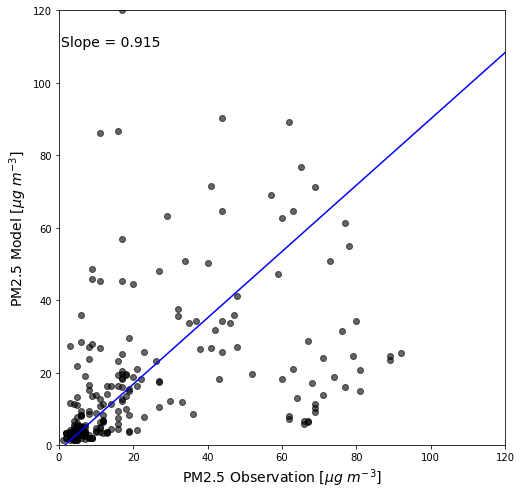

In [10]:
# Scatter Plot With Linear Regression
from scipy import stats
# Create Linear Best Fit
PM25_mod = np.delete(PM25_mod,20)
PM25_obs = np.delete(PM25_obs,20)
slope, intercept, ste_slope, ste_int, ci_grad, ci_int = smafit(X0=PM25_obs,Y0=PM25_mod,W0=None,cl=0.95,intercept=True,robust=True,rmethod='FastMCD')
b = str(round(intercept,4))
string = 'Slope = '+str(round(slope,3))
mod_for_linear   = np.arange(0,200,1)
obs_from_linear = mod_for_linear * slope + intercept
plt.figure(figsize=(8,8))
plt.scatter(PM25_obs,PM25_mod,c='k',alpha=0.6)
plt.plot(mod_for_linear,obs_from_linear, 'b')
plt.ylabel('PM2.5 Model [$\mu g$ $m^{-3}$]',fontsize=14)
plt.xlabel('PM2.5 Observation [$\mu g$ $m^{-3}$]',fontsize=14)
plt.text(0.5,110,string,fontsize=14)
plt.xlim(0,120)
plt.ylim(0,120)

In [ ]:
np.argwhere(np.isnan(PM25_obs))